In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import itertools
import math
from typing import Tuple, List

In [6]:
img = cv2.imread('eye.jpg')

In [7]:
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

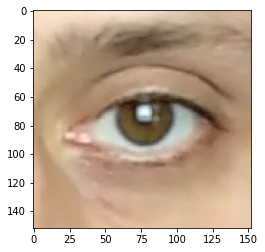

In [8]:
plt.imshow(img)

In [57]:
#access pixel value
pix=img[5,5]
print(pix)

[250 222 198]


In [9]:
##change pixel value of RGB 0 means R index
#img[50,50,0]=0
#img[50:75,50:75,0]=0
#plt.imshow(img)

In [10]:
#access pixel value at location
px=img.item(50,50,1)
print(px)

149


In [15]:
#setting new pixel value to 180 1 for G
img.itemset((50,50,1),180)
px=img.item(50,50,1)
print(px)

180


In [12]:
print(img)

[[[250 224 197]
  [250 224 197]
  [251 225 198]
  ...
  [207 180 153]
  [205 179 152]
  [203 177 150]]

 [[249 223 196]
  [249 223 196]
  [250 224 197]
  ...
  [206 179 152]
  [204 178 151]
  [203 177 150]]

 [[249 223 196]
  [249 223 196]
  [249 223 196]
  ...
  [206 179 152]
  [205 179 152]
  [205 179 152]]

 ...

 [[222 182 147]
  [218 178 143]
  [214 176 140]
  ...
  [233 202 174]
  [233 202 174]
  [232 201 173]]

 [[221 181 146]
  [217 177 142]
  [214 176 140]
  ...
  [233 202 174]
  [232 201 173]
  [232 201 173]]

 [[220 180 145]
  [217 177 142]
  [214 176 140]
  ...
  [233 202 174]
  [232 201 173]
  [232 201 173]]]


In [16]:
##daugman operator


def daugman(gray_img: np.ndarray, center: Tuple[int, int],
            start_r: int, end_r: int, step: int = 1) -> Tuple[float, int]:
    """ The function will calculate pixel intensities for the circles
        in the ``range(start_r, end_r, step)`` for a given ``center``,
        and find a circle that precedes the biggest intensity drop

        :param gray_img: grayscale picture
        :param center:  center coordinates ``(x, y)``
        :param start_r: bottom value for iris radius in pixels
        :param end_r: top value for iris radius in pixels
        :param step: step value for iris radii range in pixels

        .. attention::
            Input grayscale image should be a square, not a rectangle

        :return: intensity_value, radius
    """
    x, y = center
    intensities = []
    mask = np.zeros_like(gray_img)

    # for every radius in range
    radii = list(range(start_r, end_r, step))  # type: List[int]
    for r in radii:
        # draw circle on mask
        cv2.circle(mask, center, r, 255, 1)
        # get pixel from original image, it is faster than np or cv2
        diff = gray_img & mask
        # normalize, np.add.reduce faster than .sum()
        #            diff[diff > 0] faster than .flatten()
        intensities.append(np.add.reduce(diff[diff > 0]) / (2 * math.pi * r))
        # refresh mask
        mask.fill(0)

    # calculate delta of radius intensitiveness
    #     mypy does not tolerate var type reload
    intensities_np = np.array(intensities, dtype=np.float32)
    del intensities

    # circles intensity differences, x5 faster than np.diff()
    intensities_np = intensities_np[:-1] - intensities_np[1:]
    # aply gaussian filter
    #     GaussianBlur() faster than filter2D() with custom kernel
    # original kernel:
    # > The Gaussian filter in our case is designedin MATLAB and
    # > is a 1 by 5 (rows by columns) vector with intensity values
    # > given by vector A = [0.0003 0.1065 0.7866 0.1065 0.0003]
    intensities_np = abs(cv2.GaussianBlur(intensities_np, (1, 5), 0))
    # get maximum value
    idx = np.argmax(intensities_np)  # type: int

    # return intensity value, radius
    return intensities_np[idx], radii[idx]


def find_iris(gray: np.ndarray, *,
              daugman_start: int, daugman_end: int,
              daugman_step: int = 1, points_step: int = 1,) -> Tuple[Tuple[int, int], int]:
    """ The function will apply :func:`daugman` on every pixel in the calculated image slice.
        Basically, we are calculating where lies set of valid circle centers.
        It is assumed that iris center lies within central 1/3 of the image.

        :param gray: graysacale **square** image
        :param points_step: it will run daugman for each ``points_step``th point.
                            It has linear correlation with overall iris search speed
        :param daugman_start: bottom value for iris radius in pixels for :func:``daugman``
        :param daugman_end: top value for iris radius in pixels for :func:``daugman``
        :param daugman_step: step value for iris radii range in pixels for :func:``daugman``.
                             It has linear correlation with overall iris search speed

        :return: radius with biggest intensiveness delta on image as ``((xc, yc), radius)``
    """
    h, w = gray.shape
    if h != w:
        print('Your image is not a square!')

    # reduce step for better accuracy
    # we will look only on dots within central 1/3 of image
    single_axis_range = range(int(h / 3), h - int(h / 3), points_step)
    all_points = itertools.product(single_axis_range, single_axis_range)

    intensity_values = []
    coords = []  # List[Tuple[Tuple(int, int), int]]

    for point in all_points:
        val, r = daugman(gray, point, daugman_start, daugman_end, daugman_step)
        intensity_values.append(val)
        coords.append((point, r))

    # return the radius with biggest intensiveness delta on image
    # ((xc, yc), radius)
    # x10 faster than coords[np.argmax(values)]
    best_idx = intensity_values.index(max(intensity_values))
    return coords[best_idx]

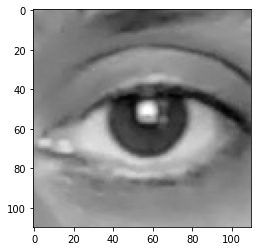

In [17]:
img = img[20:130, 20:130]
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

_ = plt.imshow(gray_img, cmap='gray')

In [18]:
# minimal iris radius -- 10px
# maximal iris radius -- 30px
answer = find_iris(gray_img, daugman_start=10, daugman_end=30, daugman_step=1, points_step=3)
print(answer)

iris_center, iris_rad = answer

((57, 54), 20)


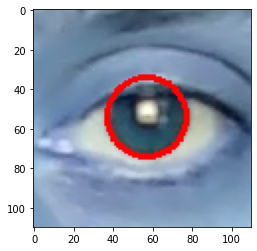

In [20]:
# plot result
out = img.copy()
cv2.circle(out, iris_center, iris_rad, (0, 0, 255), 2)
_ = plt.imshow(out[::,::,::-1])